In [1]:
import multiprocessing as mp
import os
import random as rn
import warnings
from glob import glob
from pathlib import Path

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timesynth as ts
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    rn.seed(seed)
    np.random.seed(seed)

In [2]:
data_name = "nyc_taxi"

Index(['timestamp', 'value'], dtype='object')
(10320, 2) [0 0]


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


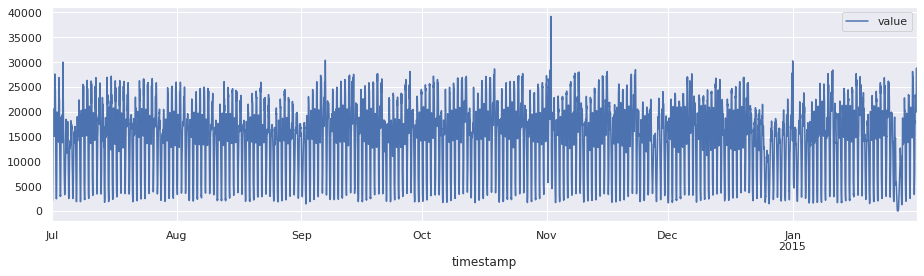

In [3]:
if data_name == "nyc_taxi":
    data_path = "data/nyc_taxi.csv"
    dt, target = "timestamp", "value"
    data = pd.read_csv(data_path)
    data[dt] = pd.to_datetime(data[dt])
elif data_name == "temperature":
    data_path = "data/temperature.csv"
    dt, target = "datetime", "Montreal"
#     data = pd.read_csv(data_path).drop(["Beersheba", "Tel Aviv District", "Eilat", "Haifa",
#                                         "Nahariyya", "Jerusalem"], axis=1)[1:-792]
    data = pd.read_csv(data_path)[[dt, target]][1:-792]
    data[dt] = pd.to_datetime(data[dt])
    data = data.set_index(dt).resample("4h").mean().interpolate(limit_area="inside").reset_index()

print(data.columns)
print(data.shape, data.isna().sum().values)
# print(data.drop(dt, axis=1).apply(np.std).sort_values())

display(data)
data.set_index(dt).plot(figsize=(13, 4))
# data.set_index(dt).plot(subplots=True, layout=(10, 3), figsize=(13, 4*10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

In [4]:
n_levels = 6
target_mean = data[target].mean()
target_std = data[target].std()

# data_fault_type = "white_noise"
# data_fault_type = "red_noise"
data_fault_type = "outliers"
# data_fault_type = "stuck-at"

# data_fault_params = dict(zip(np.arange(n_levels), target_std * np.linspace(0, 3.5, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, 4, num=n_levels)))
data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, .075, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.arange(n_levels)))

n_test = np.round(.2*len(data)).astype(int)
n_train = len(data)-n_test
n_train, n_test

(8256, 2064)

In [5]:
def inject_white_noise(data, std):
    data_ = data.copy()
    data_[target] += ts.noise.GaussianNoise(std=std).sample_vectorized(data.index.values)
    return data_

def inject_red_noise(data, tau, std):
    data_ = data.copy()
    dummy_signal = ts.signals.Sinusoidal(frequency=0)
    noise_generator = ts.noise.RedNoise(std=std, tau=tau)
    timeseries = ts.TimeSeries(dummy_signal, noise_generator=noise_generator)
    data_[target] += timeseries.sample(data.index)[0]
    return data_

def inject_outliers(data, prob, mean, std):
    data_ = data.copy()
    n_outliers = np.round(prob*len(data)).astype(int)
    n_train_outliers = np.round(prob*n_train).astype(int)
    n_test_outliers = n_outliers-n_train_outliers
    train_outlier_idxs = rn.sample(range(n_train), n_train_outliers)
    test_outlier_idxs = rn.sample(range(n_train, len(data)), n_test_outliers)
    outlier_idxs = np.concatenate((train_outlier_idxs, test_outlier_idxs))
    data_[target][outlier_idxs] = 10 * std + mean
    return data_

def inject_stuck_at(data, level, mean, std):
    data_ = data.copy()
    if level == 0:
        data_[target] = data_[target].astype(float)
        return data_
    n_stuck_at = n_train // (n_levels - 1)
    start = (level - 1) * n_stuck_at
    end = start + n_stuck_at
    data_[target][start:end] = 10 * std + mean
    return data_

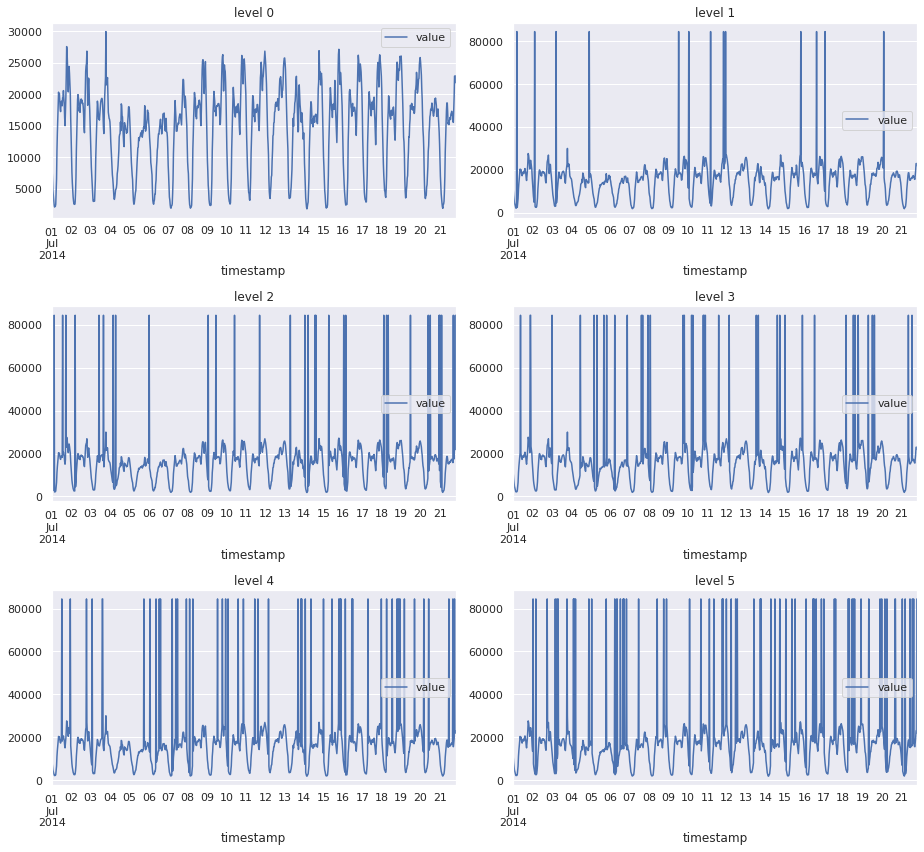

In [6]:
reset_seed()

n_subplot_rows = n_levels//2 if n_levels % 2 == 0 else n_levels//2+1
train_dfs, test_dfs, pred_dfs = dict(), dict(), dict()

fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(13, 4*n_subplot_rows))
for i in data_fault_params.keys():
    data_ = None
    if data_fault_type == "white_noise":
        data_ = inject_white_noise(data, data_fault_params[i])
    elif data_fault_type == "red_noise":
        data_ = inject_red_noise(data, data_fault_params[i], target_std)
    elif data_fault_type == "outliers":
        data_ = inject_outliers(data, data_fault_params[i], target_mean, target_std)
    elif data_fault_type == "stuck-at":
        data_ = inject_stuck_at(data, data_fault_params[i], target_mean, target_std)
    
    df_train, df_test = train_test_split(data_, shuffle=False, test_size=n_test)
    train_dfs[i] = df_train
    test_dfs[i] = df_test.reset_index(drop=True)

    train_dfs[i][:1000].plot(x=dt, y=target, ax=axes.flatten()[i], sharex=False, sharey=False,
                             title=f"level {i}")

    train_path = f"train/{Path(data_path).stem}_{data_fault_type}_level_{i}.csv"
    if not Path(train_path).exists():
        train_dfs[i].to_csv(train_path, index=False)
    else:
        train_df = pd.read_csv(train_path)
        assert np.allclose(train_df[target].values, train_dfs[i][target].values)
plt.tight_layout()
plt.show()

In [7]:
# automl_names = ["analytics-zoo", "azure_automl", "prophet", "prophet_hpo"]
automl_names = ["analytics-zoo"]
n_preds = 10
time_limit_min = 60

In [8]:
for automl_name in automl_names:
    pred_dfs[automl_name] = dict()
    for i in range(len(data_fault_params)):
        pred_dfs[automl_name][i] = list()
        pred_paths = glob(f"pred/{Path(data_path).stem}_{data_fault_type}_level_{i}_" \
                          f"{automl_name}_{time_limit_min}_min_*.csv")
        for pred_path in pred_paths[:n_preds]:
            df_pred = pd.read_csv(pred_path)
            df_pred.name = pred_path[-12:-4]
            df_pred[dt] = pd.to_datetime(df_pred[dt])
            pred_dfs[automl_name][i].append(df_pred)

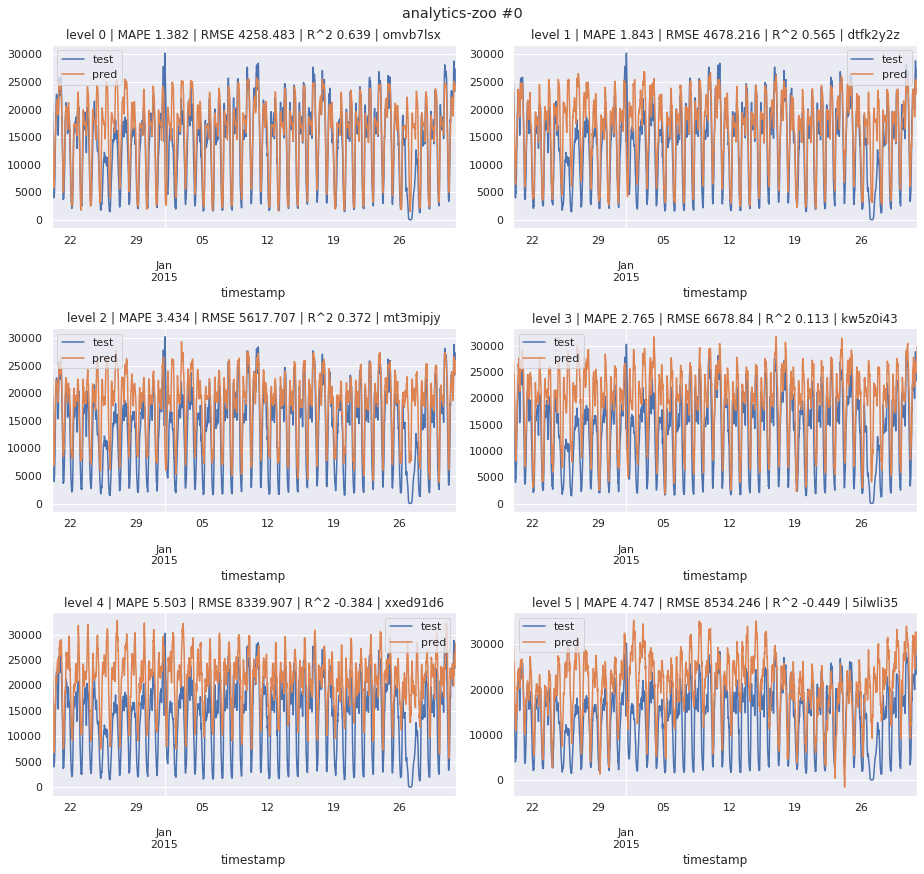

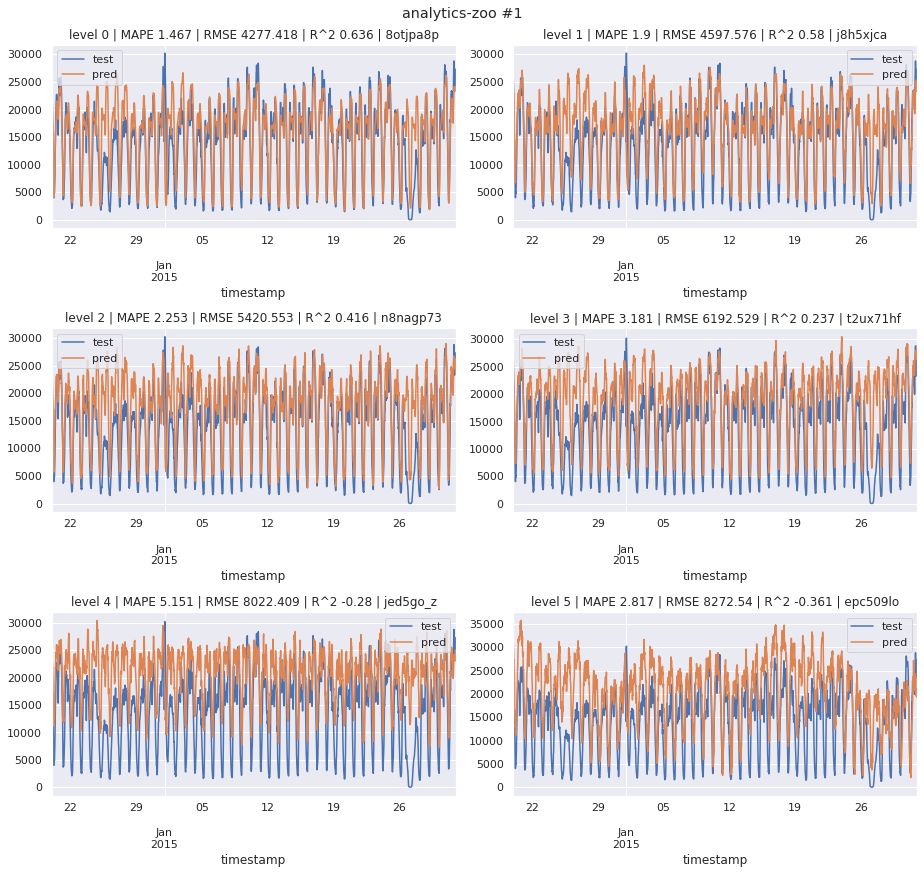

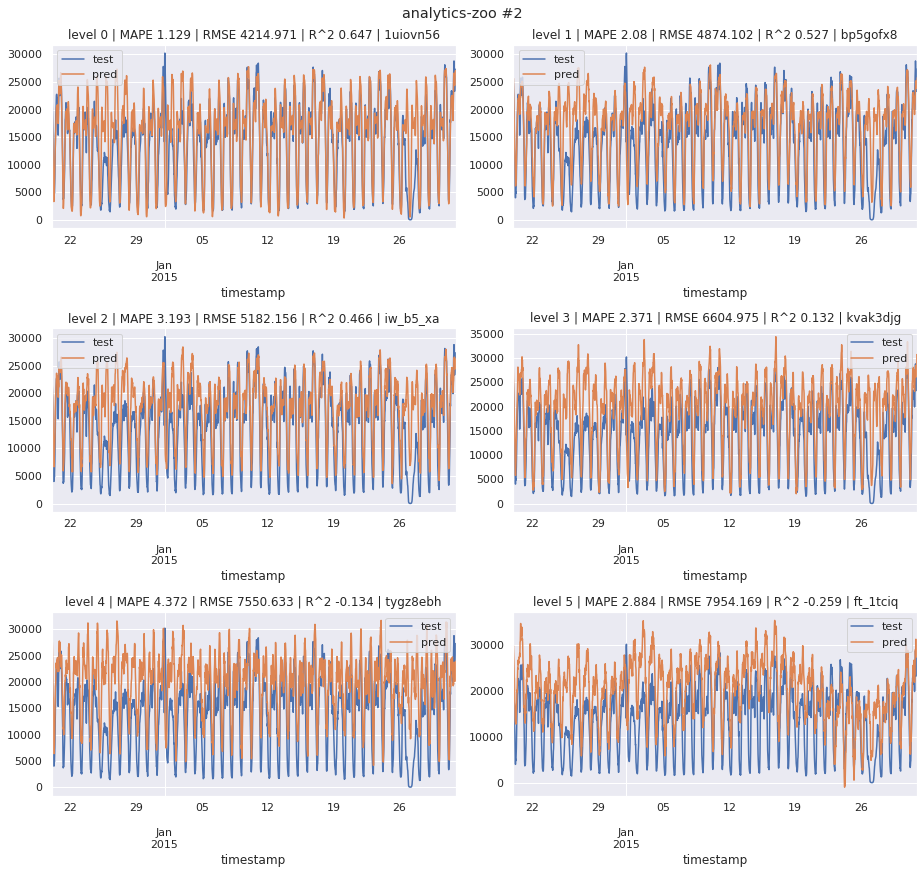

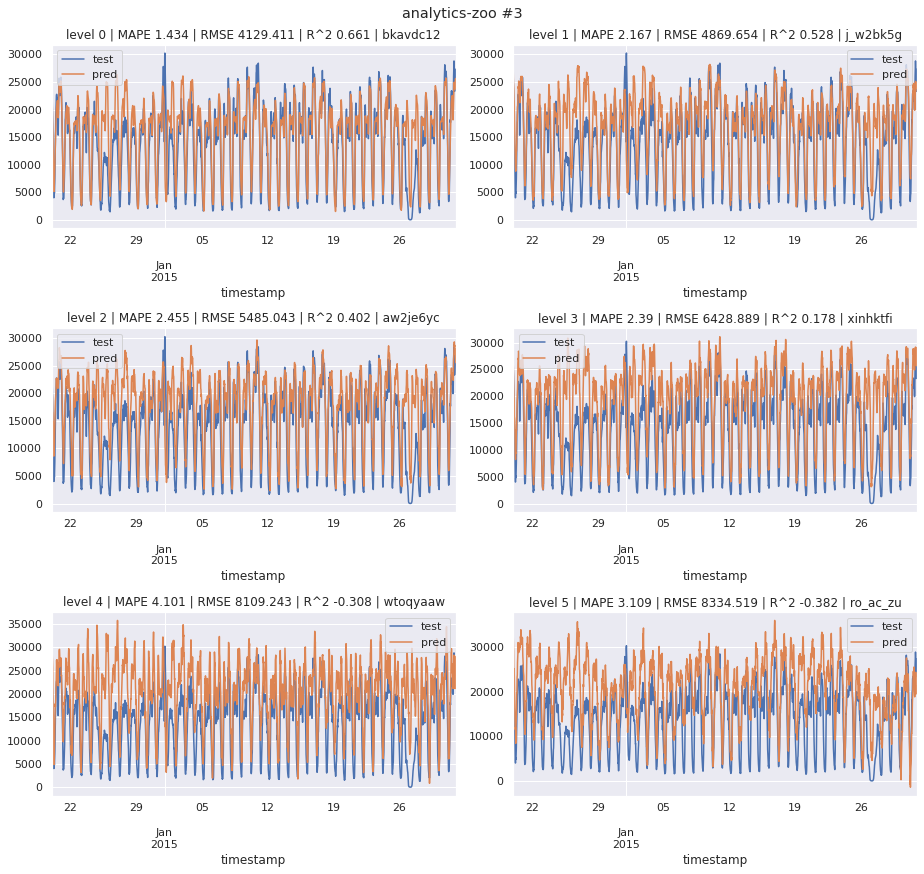

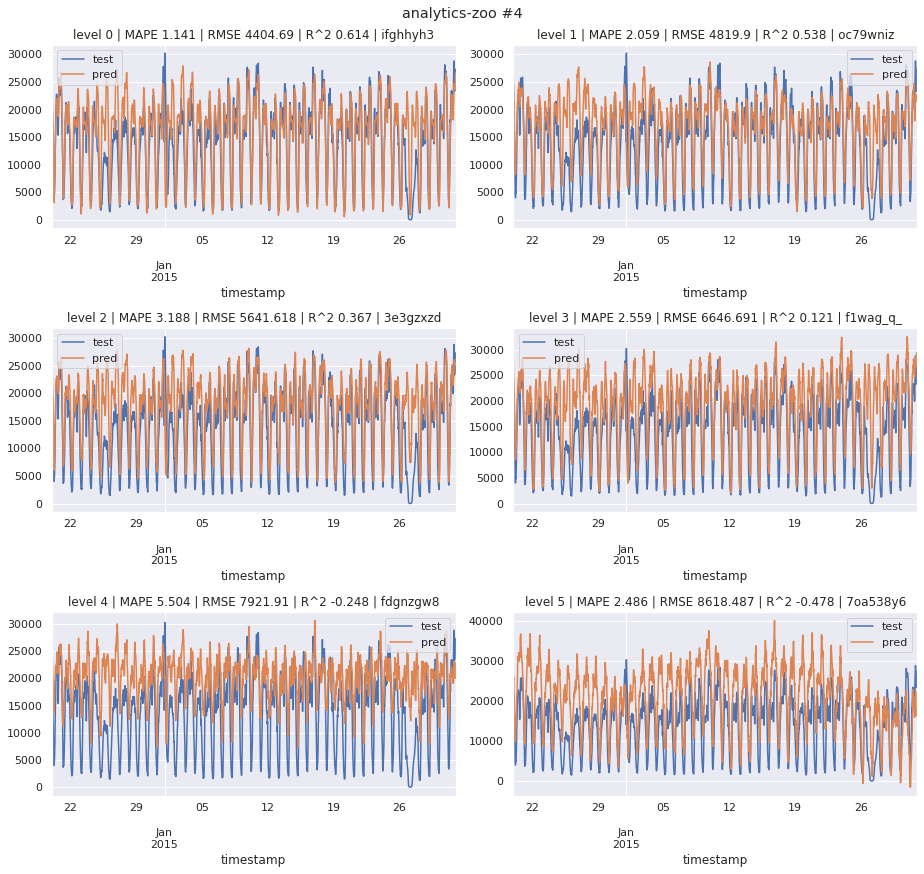

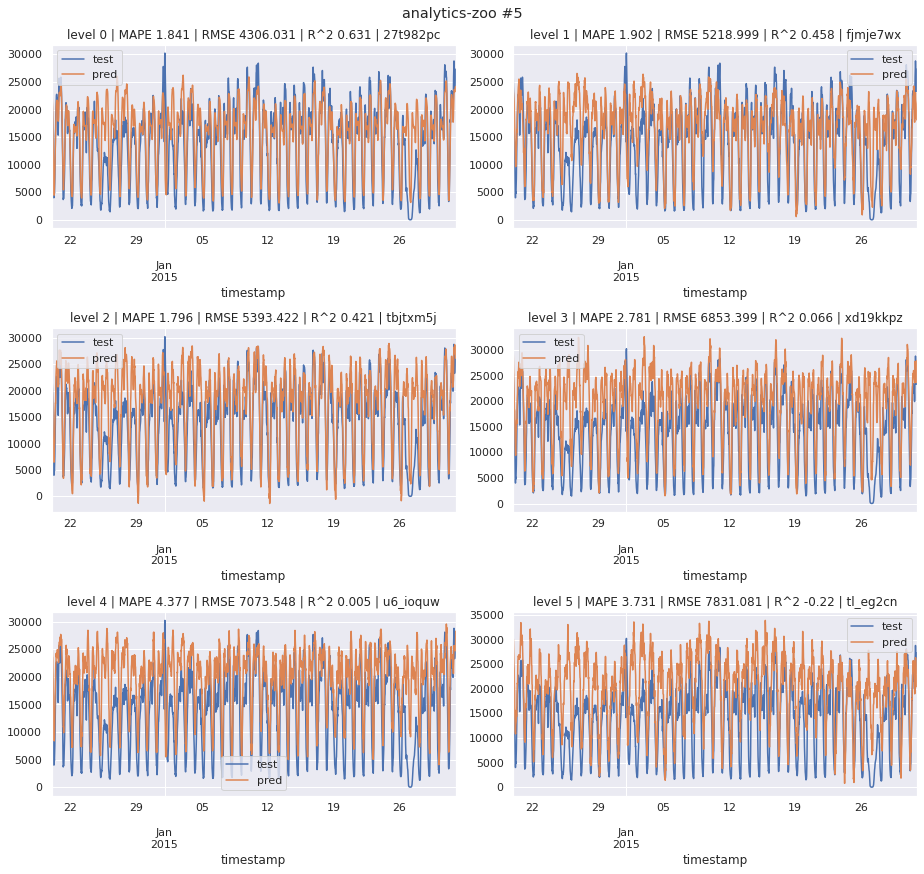

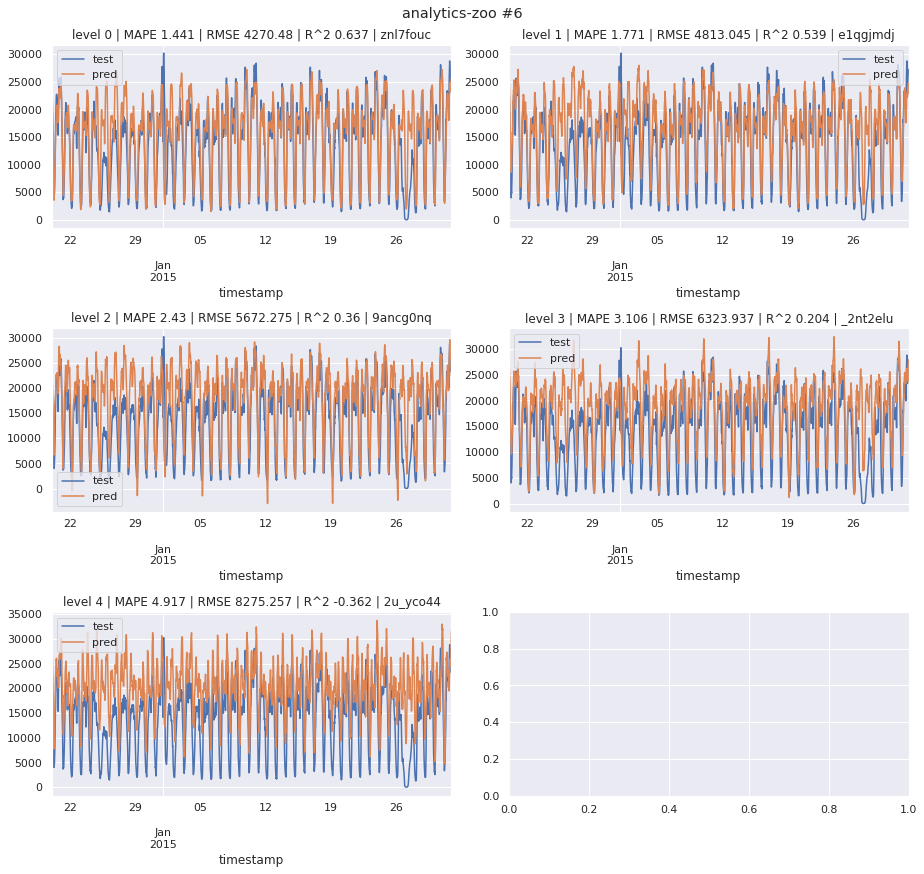

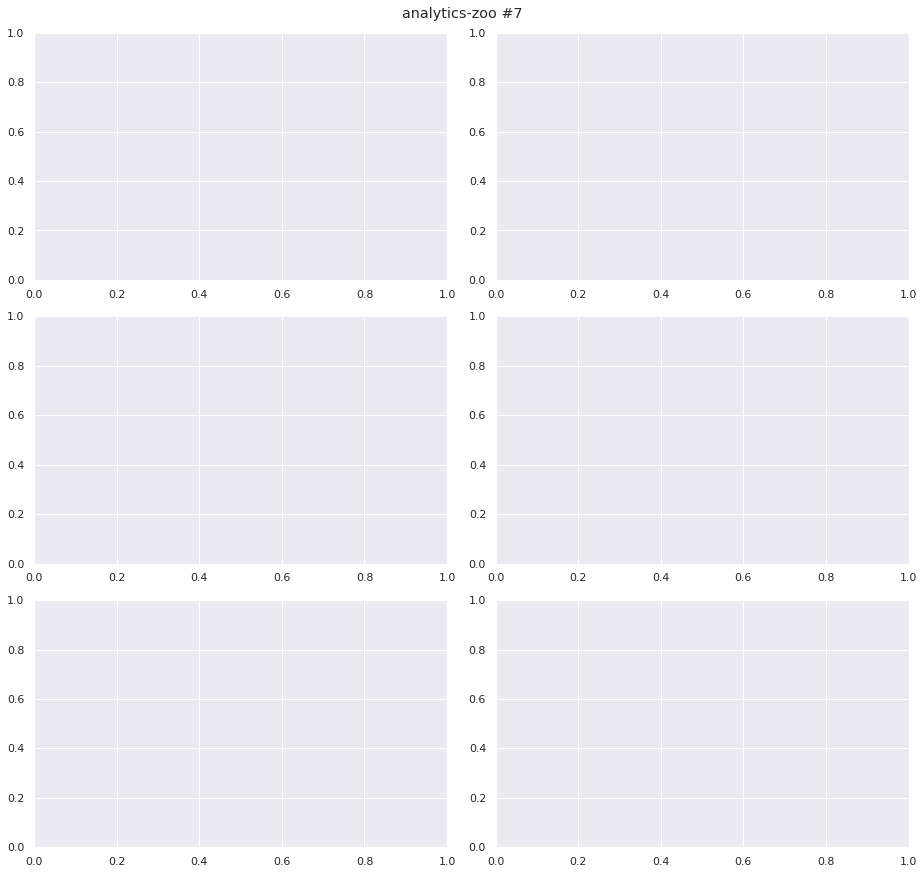

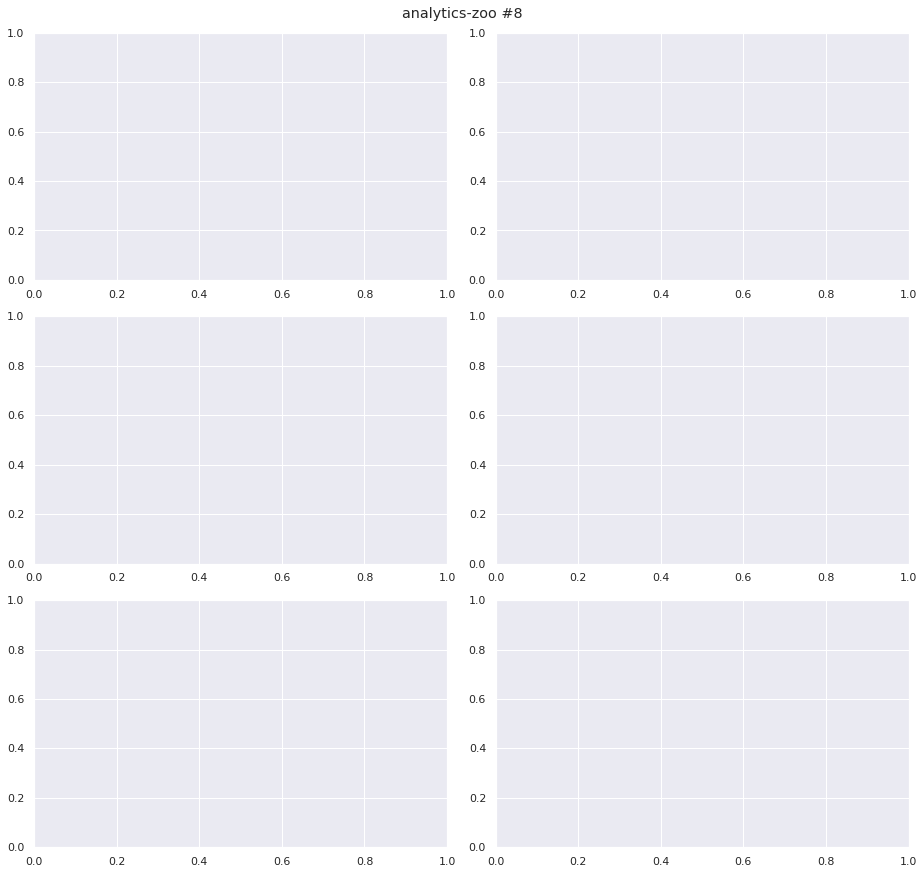

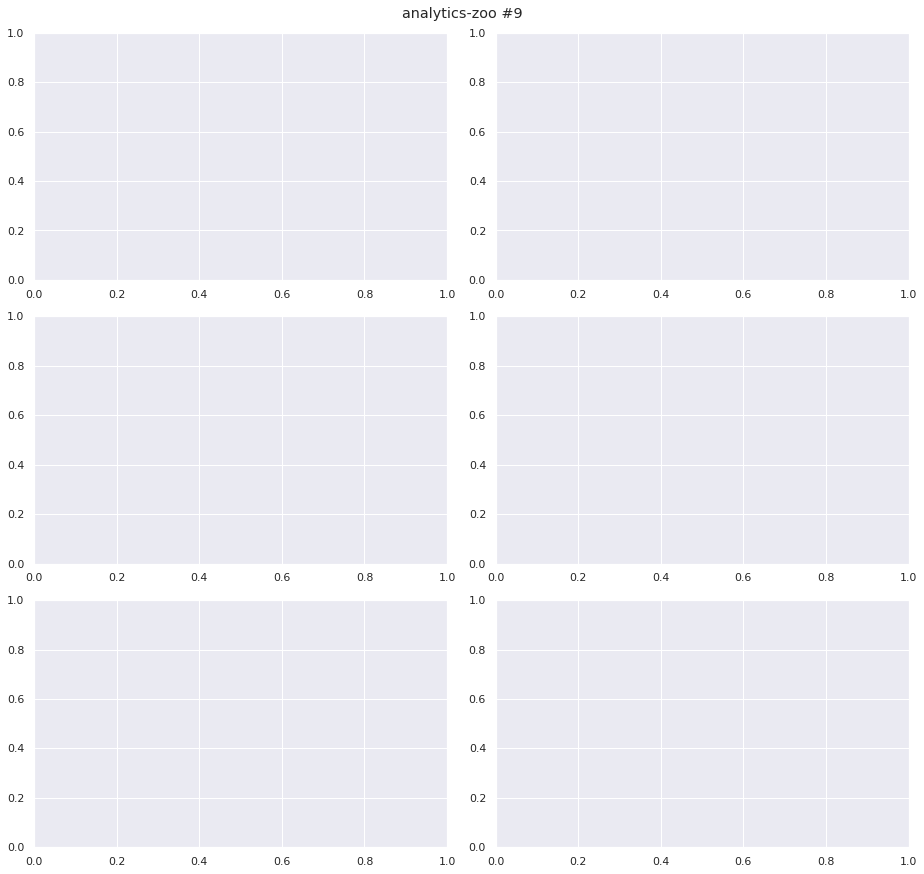

In [11]:
df_test = test_dfs[0]
results = []
for automl_name in automl_names:
    for i in range(n_preds):
        if automl_name == "prophet" and i:
            break
        fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(13, 4*n_subplot_rows))
        for j in data_fault_params.keys():
            try:
                df_pred = pred_dfs[automl_name][j][i]
            except:
                continue

            rmse = np.sqrt(mean_squared_error(df_test[target], df_pred[target]))
            mape = mean_absolute_percentage_error(df_test[target], df_pred[target])
            r2 = r2_score(df_test[target], df_pred[target])
            results.append({"metric": "MAPE", "automl_name": automl_name, "level": j, "score": mape})
            results.append({"metric": "RMSE", "automl_name": automl_name, "level": j, "score": rmse})
            results.append({"metric": "R^2", "automl_name": automl_name, "level": j, "score": r2})
            df = pd.DataFrame({dt: df_test[dt], "test": df_test[target], "pred": df_pred[target]})
            df.name = automl_name
            df.plot(x=dt, ax=axes.flatten()[j], sharex=False, sharey=False,
                    title=f"level {j} | MAPE {np.round(mape, 3)} | RMSE {np.round(rmse, 3)} | " \
                          f"R^2 {np.round(r2, 3)} | {df_pred.name}")
        plt.tight_layout()
        plt.suptitle(f"{automl_name} #{i}", y=1.01)
        plt.show()

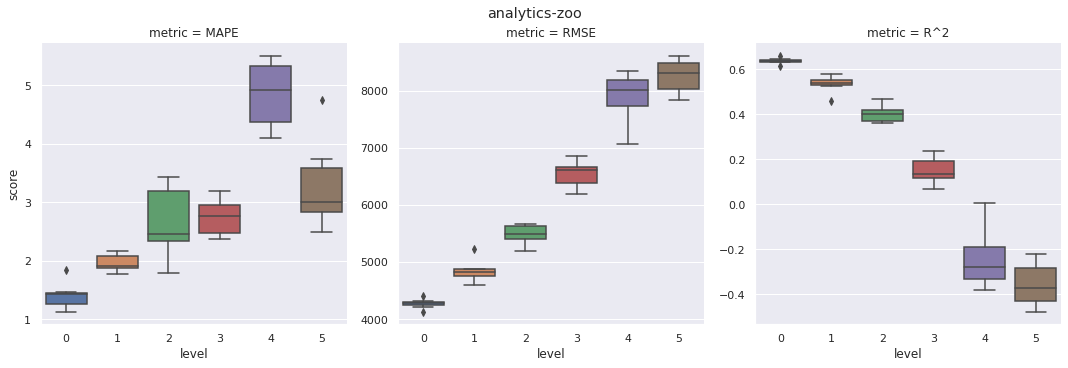

In [12]:
df_results = pd.DataFrame(results)
for automl_name in automl_names:
    if automl_name == "prophet":
        continue
    df = df_results[(df_results["automl_name"] == automl_name)]
    sns.catplot(x="level", y="score", col="metric", data=df, kind="box", sharex=False, sharey=False)
#     plt.ylim(0, 1)
    plt.tight_layout()
    plt.suptitle(automl_name, y=1.02)
    plt.show()

,metric,mean,count
automl_name,,analytics-zoo,analytics-zoo
level,,,
0,MAPE,1.405027,7
1,MAPE,1.960194,7
2,MAPE,2.678346,7
3,MAPE,2.736149,7
4,MAPE,4.846582,7
5,MAPE,3.295724,6


,metric,mean,count
automl_name,,analytics-zoo,analytics-zoo
level,,,
0,RMSE,4265.926216,7
1,RMSE,4838.784536,7
2,RMSE,5487.538991,7
3,RMSE,6532.751320,7
4,RMSE,7898.986686,7
5,RMSE,8257.507142,6


,metric,mean,count
automl_name,,analytics-zoo,analytics-zoo
level,,,
0,R^2,0.637889,7
1,R^2,0.533601,7
2,R^2,0.400485,7
3,R^2,0.150198,7
4,R^2,-0.244527,7
5,R^2,-0.357956,6


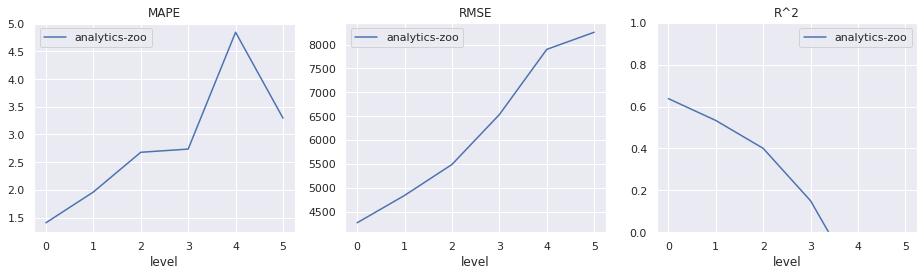

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for ax, metric in zip(axes.flatten(), ["MAPE", "RMSE", "R^2"]):
    df = df_results[df_results["metric"] == metric]
    df = df.groupby(["level", "automl_name"])["score"].aggregate(["mean", "count"]).unstack()
    df["metric"] = metric
    df = df[["metric", "mean", "count"]]
    display(df)
    df_ = df.drop(["metric", "count"], axis=1)["mean"]
    df_.columns.name = None
    df_.plot(ax=ax, title=metric)
axes.flatten()[2].set_ylim(0, 1)
plt.tight_layout()
plt.show()